# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Hyperparameters

In [1]:
TRAINING_PERCENT_PARAMETER = .2     # percentage of data to train against
K_NEAREST_NEIGHEBORS_PARAM = 2      # for KNN
DECISION_TREE_MAX_DEPTH_PARAM = 2   # for Decision Tree
SVM_C_PARAM = 1                     # SVM
SVM_GAMMA_PARAM = 0.1               # 
SVM_KERNEL_PARAM = 'rbf'            # 
DEBUG_PARAMETER = True              # print out debug information
PARAM_FINAL_IMAGES = False

# Readying the data and training data

### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
from matplotlib import pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , confusion_matrix, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [3]:
local_prefix = "/Users/davidstange/Development/github/davestange/ml_banking_marketing/"
df = pd.read_csv(f'{local_prefix}data/bank-additional-full.csv', sep = ';')

In [4]:
df.y.value_counts(normalize=True)

y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64

### Problem 3: Understanding the Features

Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.
> The goal of the task is to predict the success of the marketing campaign (feature 'y') using data gathered/available _prior_ to the call. Compare various models to the baseline to determine which models are the most accurate; explain findings.

### Clean up the data

In [5]:
def drop_unknown_vals(df, cols):
    for col in cols:
        df = df[df[col] != 'unknown']
    return df

def map_booleans(df, cols):
    for col in cols:
        df[f"is_{col}"] = df[col].map({ "no": 0, "yes": 1, "n": 0, "y": 1})
    return df

df = drop_unknown_vals(df, ['default', 'housing', 'loan', 'education'])
df = map_booleans(df, ['default', 'housing', 'loan', 'y'])
df["is_cellular"] = df.contact.map({ "telephone": 0, "cellular": 1})

len(df)

30667

## Features

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [6]:
TARGET_FEATURE = 'is_y'
TRAINING_FEATURES = [ 
    'age',                                                  # numeric
    'is_default', 'is_housing', 'is_loan', 'is_cellular',   # boolean
    'education',                                            # ordinal encoding
    'job', 'marital', 'month', 'day_of_week',               # one-hot encoding
    TARGET_FEATURE                                          # training feature (will ignore later)
]

# set transformer of remaining categorical features
col_trans = make_column_transformer(
    (OrdinalEncoder(categories = [['illiterate', 'high.school', 'professional.course', 'basic.4y', 'university.degree', 'basic.6y', 'basic.9y']]), ['education']),
    (OneHotEncoder(drop = 'if_binary'), ['job', 'marital', 'month', 'day_of_week']),
    remainder='passthrough')

## Prepare the training set

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [63]:
from sklearn.metrics import auc as skl_auc

tmp = df[TRAINING_FEATURES]
X_train, X_test, y_train, y_test = train_test_split(tmp.drop(TARGET_FEATURE, axis = 1), 
                                                    tmp[TARGET_FEATURE],
                                                    train_size=TRAINING_PERCENT_PARAMETER,
                                                    random_state=42,
                                                    stratify = df[TARGET_FEATURE])
if DEBUG_PARAMETER:
    print(f"The training set has {len(y_train)} rows")
    print(f"The test set has {len(y_test)} rows")
    print(f"The target feature is {TARGET_FEATURE} and the {len(X_train.columns)} training columns are {[x for x in X_train.columns]}")

    
def create_confusion_matrix(model_name, predictions, y_test):
    cm = confusion_matrix(predictions, y_test)
    sns.heatmap(cm, annot=True, fmt = "d", cmap = "Blues", annot_kws={"size": 20}, cbar = False)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion matrix for {model_name}')
    sns.set(font_scale = 2)
    
def create_confusion_matrix_2(model_name, predictions, y_test):
    cm = confusion_matrix(predictions, y_test)
    disp1 = ConfusionMatrixDisplay(cm)
    disp1.plot()
    
def create_roc_curve(model, X_test, y_test):
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc_value = skl_auc(fpr, tpr)

    disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
    disp2.plot()

all_runs = []
class ModelTrainer:
    def __init__(self, model_name, actual_model, generate_charts=True):
        self.start_time = time.time()
        self.model_name = model_name
        self.model = actual_model
        self.generate_charts = generate_charts
        # self.predictions = None
        
    def elapsed(self):
        elapsed_time = time.time() - self.start_time
        return f"{elapsed_time:.4f} secs"
    
    def model_predict(self, X, is_continuous):
        prediction = self.model.predict(X)
        if is_continuous:
            prediction = (prediction >= 0.5).astype(int)
        return prediction
    
    def chart_roc_and_confusion(self, is_continuous):
        fig, ax = plt.subplots(1, 2)
        if PARAM_FINAL_IMAGES:
            fig.set_size_inches(20, 12)
        else:
            fig.set_size_inches(15, 5)

        preds = self.model_predict(X_test, is_continuous)

        # Confusion Matrix
        conf_matrix = confusion_matrix(y_test, preds)
        disp1 = ConfusionMatrixDisplay(conf_matrix)
        disp1.plot(ax=ax[0])

        # ROC Curve
        y_score = None
        if not is_continuous:
            y_score = self.model.predict_proba(X_test)[:, 1]
        else:
            y_score = self.model.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, y_score) # , pos_label='Yes'
        roc_auc_value = skl_auc(fpr, tpr)

        disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
        disp2.plot(ax=ax[1])

    def run(self, is_continuous=False):
        training_features = 0 if self.model_name == "Dummy" else len(TRAINING_FEATURES) - 1
        self.model.fit(X_train, y_train)
        train_accuracy = accuracy_score(self.model_predict(X_train, is_continuous), y_train)
        self.predictions = self.model_predict(X_test, is_continuous)
        test_accuracy = accuracy_score(self.predictions, y_test) 
        all_runs.append(f"| {self.model_name} | {training_features} | {self.elapsed()} | {train_accuracy:4f} | {test_accuracy:4f} |")

        # ax = create_plots(2)
        # create_confusion_matrix_2(self.model_name, self.predictions, y_test, ax[0])
        # create_roc_curve(self.model, X_test, y_test, ax[1])
        if self.generate_charts:
            self.chart_roc_and_confusion(is_continuous)

The training set has 6133 rows
The test set has 24534 rows
The target feature is is_y and the 10 training columns are ['age', 'is_default', 'is_housing', 'is_loan', 'is_cellular', 'education', 'job', 'marital', 'month', 'day_of_week']


# Determine Hyperparameters

## K Nearest Neighbors

In [17]:
pipeline = Pipeline([
    ('transformer', col_trans),
    ('regression', KNeighborsClassifier())
])
parameters_to_try = {'regression__n_neighbors': np.array(range(1, 20))}

from sklearn.model_selection import GridSearchCV
model_finder = GridSearchCV(estimator = pipeline, 
                            param_grid = parameters_to_try, 
                            scoring = "accuracy",
                            n_jobs=-1,      # parallelization
                            cv = 5)
model_finder.fit(X_train, y_train)
model_finder.best_estimator_

,steps,"[('transformer', ...), ('regression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ordinalencoder', ...), ('onehotencoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Decision Tree

In [120]:
pipeline = Pipeline([
    ('transformer', col_trans),
    ('regression', DecisionTreeClassifier(criterion='entropy'))
])
parameters_to_try = {'regression__max_depth': np.array(range(1, 20))}

from sklearn.model_selection import GridSearchCV
model_finder = GridSearchCV(estimator = pipeline, 
                            param_grid = parameters_to_try, 
                            scoring = "accuracy",
                            n_jobs=-1,      # parallelization
                            cv = 5)
model_finder.fit(X_train, y_train)
model_finder.best_estimator_

,steps,"[('transformer', ...), ('regression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ordinalencoder', ...), ('onehotencoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## Ridge

In [68]:
for alpha in [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001]:
    modeller = ModelTrainer(
        f"Ridge (alpha={alpha}) with StandardScaler", 
        Pipeline([
            ('transformer', col_trans),
            ('scale', StandardScaler(with_mean=False)),
            ('regression', Ridge(alpha=alpha))
        ]),
        generate_charts=False
    )
    modeller.run(True)

# Training

### Problem 7: A Baseline Model

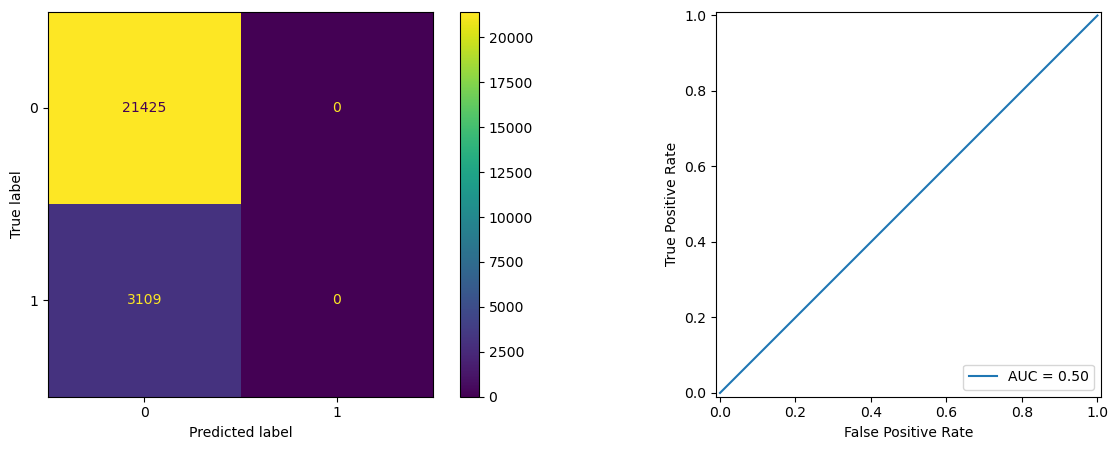

In [8]:
modeller = ModelTrainer(
    "Dummy", 
    DummyClassifier()
)
modeller.run()

### Logistic Regression

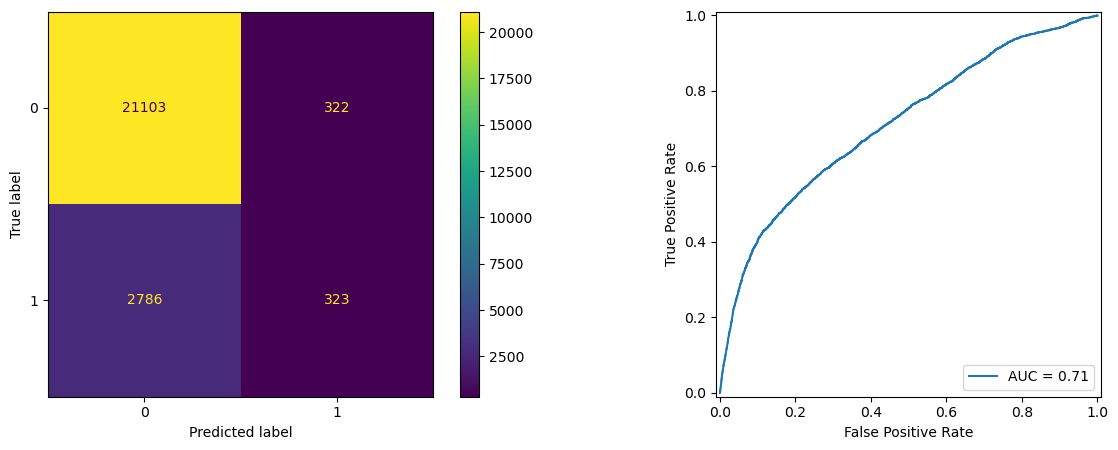

In [9]:
modeller = ModelTrainer(
    "LogisticRegression", 
    Pipeline([
        ('transformer', col_trans),
        ('regression', LogisticRegression(solver='liblinear', random_state=42, fit_intercept=True))
    ])
)
modeller.run()

### K-Nearest Neighbors

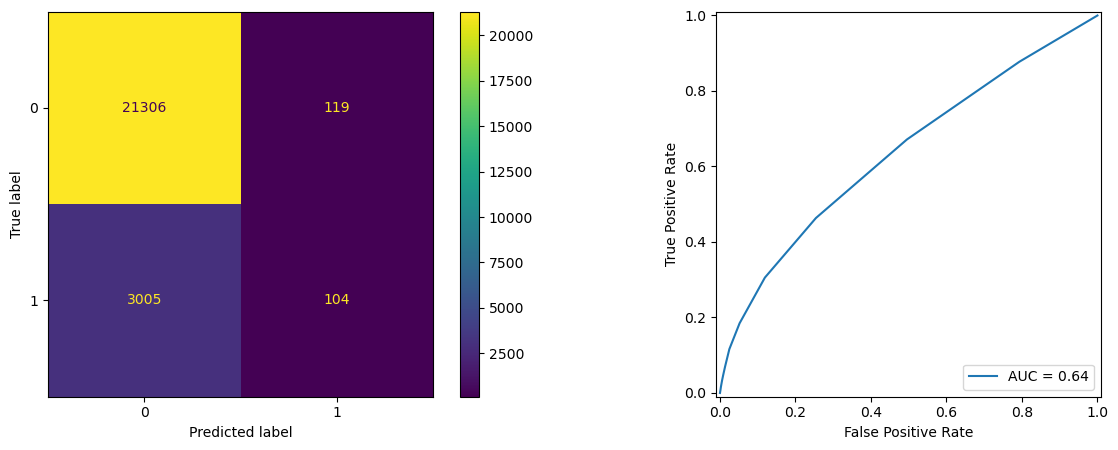

In [10]:
# for i in range(1, 20):
i = 16

pipeline = Pipeline([
    ('transformer', col_trans),
    ('regression', KNeighborsClassifier(n_neighbors=i))
])

modeller = ModelTrainer(
    f"KNN with {i} neighbors", 
    pipeline
)
modeller.run()

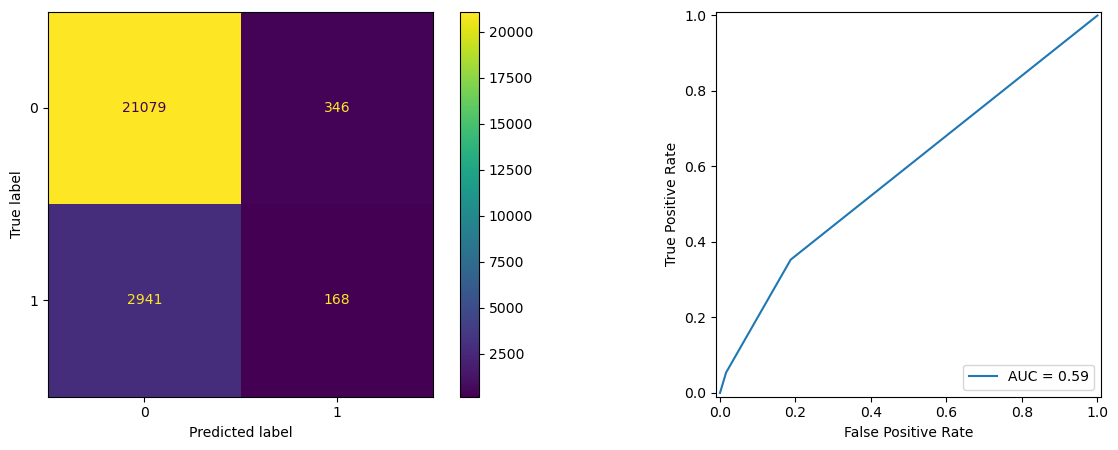

In [11]:
modeller = ModelTrainer(
    f"KNN with {K_NEAREST_NEIGHEBORS_PARAM} neighbors", 
    Pipeline([
        ('transformer', col_trans),
        ('regression', KNeighborsClassifier(n_neighbors=K_NEAREST_NEIGHEBORS_PARAM))
    ])
)
modeller.run()


### Decision Tree

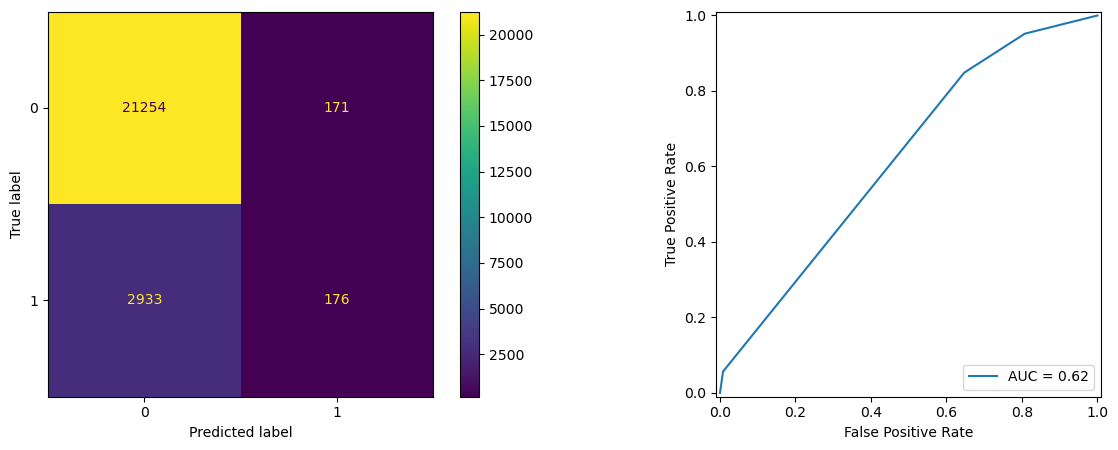

In [12]:
DECISION_TREE_MAX_DEPTH_PARAM=2
decision_tree = DecisionTreeClassifier(criterion='entropy', max_depth=DECISION_TREE_MAX_DEPTH_PARAM)

modeller = ModelTrainer(
    f"DecisionTreeClassifier with max_depth={K_NEAREST_NEIGHEBORS_PARAM}", 
    Pipeline([
        ('transformer', col_trans),
        ('regression', decision_tree)
    ])
)
modeller.run()


Text(0.5, 0.98, 'Decision Tree Classifier')

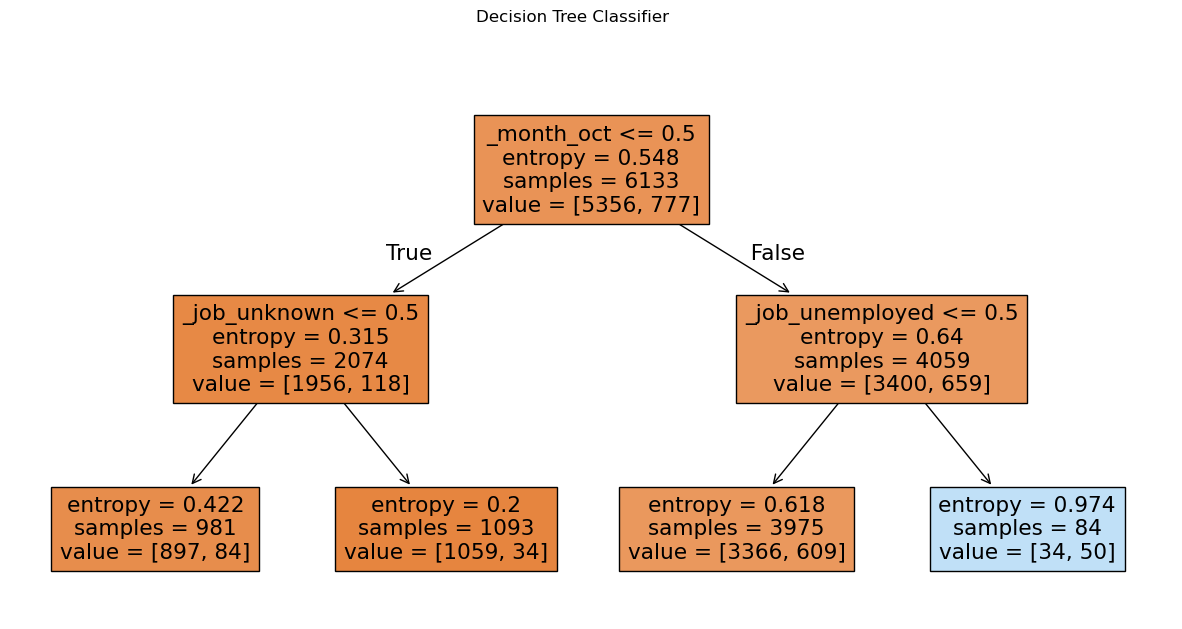

In [13]:


# get cleaned up feature names
feature_names = []
feature_names += TRAINING_FEATURES
feature_names += col_trans.get_feature_names_out().tolist()
feature_names

feature_names = [x.replace('ordinalencoder__', '_').replace('onehotencoder__', '_').replace('remainder__', '_') for x in feature_names]

fig = plt.figure(figsize=(15,7))
_ = tree.plot_tree(decision_tree,
                   feature_names=feature_names,
                   filled=True)
plt.suptitle("Decision Tree Classifier")

### Support Vector Machines

In [14]:
pipeline = Pipeline([
    ('transformer', col_trans),
    ('regression', SVC())
])
parameters_to_try = {
    # 'regression__C': [0.1, 1, 10, 100, 1000], 
	'regression__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
	'regression__kernel': ['linear']
}


from sklearn.model_selection import GridSearchCV
model_finder = GridSearchCV(estimator = pipeline, 
                            param_grid = parameters_to_try, 
                            scoring = "accuracy",
                            cv = 5)
model_finder.fit(X_train, y_train)
model_finder.best_estimator_

,steps,"[('transformer', ...), ('regression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ordinalencoder', ...), ('onehotencoder', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


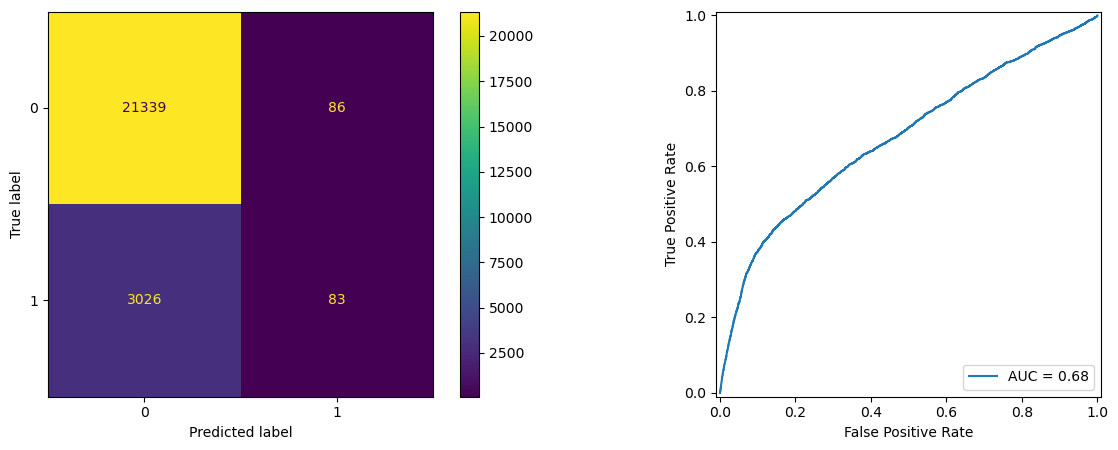

In [15]:
svc = SVC(kernel=SVM_KERNEL_PARAM, gamma=SVM_GAMMA_PARAM, C=SVM_C_PARAM, probability=True)

modeller = ModelTrainer(
    f"SVM (kernel={SVM_KERNEL_PARAM}, gamma={SVM_GAMMA_PARAM}, C={SVM_C_PARAM})", 
    Pipeline([
        ('transformer', col_trans),
        ('regression', svc)
    ])
)
modeller.run()

### Ridge Models

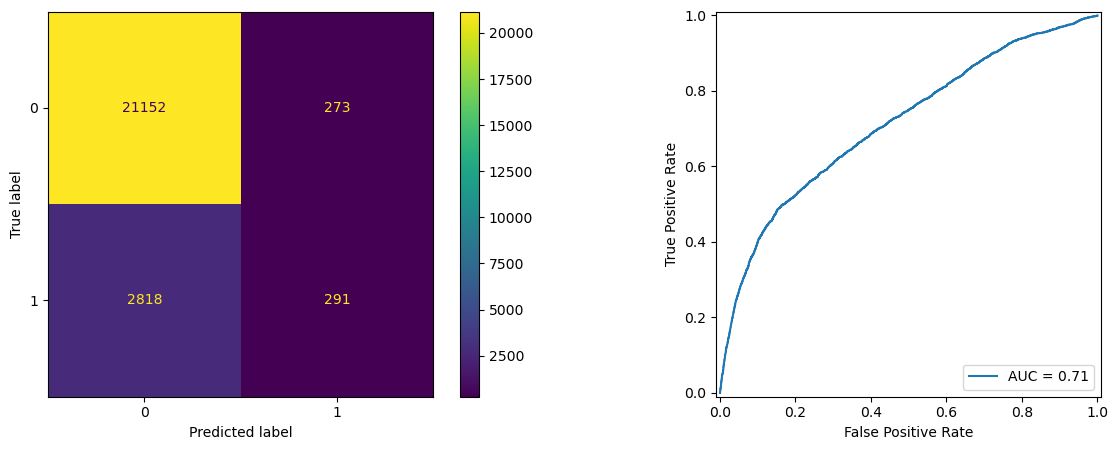

In [59]:
alpha = 0.1
modeller = ModelTrainer(
    f"Ridge (alpha={alpha}) with StandardScaler", 
    Pipeline([
        ('transformer', col_trans),
        # ('scale', StandardScaler(with_mean=False)),
        ('regression', Ridge(alpha=alpha))
    ])
)
modeller.run(True)

## Get output

In [69]:
for run in all_runs:
    print(run)

| Ridge (alpha=100) | 10 | 0.0543 secs | 0.873145 | 0.873441 |
| Ridge (alpha=10) | 10 | 0.0254 secs | 0.875102 | 0.874093 |
| Ridge (alpha=1) | 10 | 0.0256 secs | 0.876406 | 0.873726 |
| Ridge (alpha=0.1) | 10 | 0.0255 secs | 0.876406 | 0.874012 |
| Ridge (alpha=0.01) | 10 | 0.0249 secs | 0.876406 | 0.874012 |
| Ridge (alpha=0.001) | 10 | 0.0247 secs | 0.876406 | 0.874012 |
| Ridge (alpha=0.0001) | 10 | 0.0253 secs | 0.876406 | 0.873971 |
| Ridge (alpha=100) with StandardScaler | 10 | 0.0610 secs | 0.875591 | 0.874052 |
| Ridge (alpha=10) with StandardScaler | 10 | 0.0267 secs | 0.876406 | 0.873849 |
| Ridge (alpha=1) with StandardScaler | 10 | 0.0245 secs | 0.876406 | 0.873930 |
| Ridge (alpha=0.1) with StandardScaler | 10 | 0.0250 secs | 0.876406 | 0.873971 |
| Ridge (alpha=0.01) with StandardScaler | 10 | 0.0239 secs | 0.876406 | 0.873971 |
| Ridge (alpha=0.001) with StandardScaler | 10 | 0.0238 secs | 0.876406 | 0.873971 |
| Ridge (alpha=0.0001) with StandardScaler | 10 | 0.0242 s

## Questions and Next Steps

I had a number of questions with this assignment. Any assistance here would be appreciated:

1) None of the models outperformed the dummy model (87.5% accuracy), due to 87.3% of the answers were No. Is this (not being to outperform the dummy model) a normal scenario or are my models not complex enough? What are additional areas that I should be considering with my models? Are they too naive? Do they not have sufficient hyperparameters?

2) The only charts that I could conceive of for this model is the standard decision tree visualization (which I included). With a binary classification and close to 50 features, I struggled to find reasonable visualizations. With 50 features displaying decision tree boundaries isn't _remotely_ feasible. Outside of the visualizations that I added (confusion matrix & decision tree) - what other charts would you want to see here?

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

# Model Comparison

## Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Features | Train Time | Train Accuracy | Test Accuracy |
| ----- | -------- | ---------- | -------------  | -----------   |
| Dummy | 0 | 0.0067 secs | 0.872642 | 0.874783 |
| LogisticRegression | 10 | 0.0711 secs | 0.877174 | 0.873201 |
| DecisionTreeClassifier, max_depth=1 | 10 | 0.0588 secs | 0.874783 | 0.872642 |
| DecisionTreeClassifier, max_depth=2 | 10 | 0.0328 secs | 0.874783 | 0.872642 |
| KNN with 16 neighbors | 10 | 3.8013 secs | 0.877826 | 0.871896 |
| SVM (kernel=linear) | 10 | 3.2228 secs | 0.875217 | 0.872083 |
| SVM (kernel=poly) | 10 | 5.3204 secs | 0.874783 | 0.872642 |
| SVM (kernel=poly, gamma=scale, coef0=1, degree=8) | 10 | 45.2492 secs | 0.878478 | 0.872781 |
|  |  |  |  |  |
| Dummy | 0 | 0.0049 secs | 0.873308 | 0.873278 |
| LogisticRegression | 10 | 0.0306 secs | 0.876243 | 0.873319 |
| KNN with 16 neighbors | 10 | 2.5952 secs | 0.875754 | 0.872667 |
| KNN with 2 neighbors | 10 | 1.4032 secs | 0.902006 | 0.866023 |
| DecisionTreeClassifier with max_depth=2 | 10 | 0.0515 secs | 0.875917 | 0.873482 |
| SVM (kernel=rbf, gamma=0.1, C=1) | 10 | 4.0566 secs | 0.879830 | 0.873156 |
|  |  |  |  |  |
| Ridge (alpha=100) | 10 | 0.0543 secs | 0.873145 | 0.873441 |
| Ridge (alpha=10) | 10 | 0.0254 secs | 0.875102 | 0.874093 |
| Ridge (alpha=1) | 10 | 0.0256 secs | 0.876406 | 0.873726 |
| Ridge (alpha=0.1) | 10 | 0.0255 secs | 0.876406 | 0.874012 |
| Ridge (alpha=0.01) | 10 | 0.0249 secs | 0.876406 | 0.874012 |
| Ridge (alpha=0.001) | 10 | 0.0247 secs | 0.876406 | 0.874012 |
| Ridge (alpha=0.0001) | 10 | 0.0253 secs | 0.876406 | 0.873971 |
| Ridge (alpha=10000) with StandardScaler | 10 | 0.0493 secs | 0.873308 | 0.873278 |
| Ridge (alpha=1000) with StandardScaler | 10 | 0.0288 secs | 0.874939 | 0.874175 |
| Ridge (alpha=100) with StandardScaler | 10 | 0.0258 secs | 0.875591 | 0.874052 |
| Ridge (alpha=10) with StandardScaler | 10 | 0.0248 secs | 0.876406 | 0.873849 |
| Ridge (alpha=1) with StandardScaler | 10 | 0.0240 secs | 0.876406 | 0.873930 |
| Ridge (alpha=0.1) with StandardScaler | 10 | 0.0238 secs | 0.876406 | 0.873971 |
| Ridge (alpha=0.01) with StandardScaler | 10 | 0.0242 secs | 0.876406 | 0.873971 |
| Ridge (alpha=0.001) with StandardScaler | 10 | 0.0248 secs | 0.876406 | 0.873971 |
| Ridge (alpha=0.0001) with StandardScaler | 10 | 0.0240 secs | 0.876406 | 0.873971 |

| Model | Features | Train Time | Train Accuracy | Test Accuracy |
| ----- | -------- | ---------- | -------------  | -----------   |
| Dummy | 0 | 0.0067 secs | 0.872642 | 0.874783 |
| LogisticRegression | 10 | 0.0711 secs | 0.877174 | 0.873201 |
| KNN with 1 neighbors | 10 | 3.3400 secs | 0.986739 | 0.812689 |
| KNN with 10 neighbors | 10 | 3.7563 secs | 0.879130 | 0.871617 |
| DecisionTreeClassifier, max_depth=1 | 10 | 0.0588 secs | 0.874783 | 0.872642 |
| DecisionTreeClassifier, max_depth=2 | 10 | 0.0328 secs | 0.874783 | 0.872642 |
| DecisionTreeClassifier, max_depth=3 | 10 | 0.0503 secs | 0.875761 | 0.872083 |
| DecisionTreeClassifier, max_depth=4 | 10 | 0.0296 secs | 0.877500 | 0.871617 |
| DecisionTreeClassifier, max_depth=5 | 10 | 0.0287 secs | 0.880652 | 0.869986 |
| DecisionTreeClassifier, max_depth=6 | 10 | 0.0295 secs | 0.884565 | 0.870033 |
| DecisionTreeClassifier, max_depth=7 | 10 | 0.0319 secs | 0.887500 | 0.869707 |
| DecisionTreeClassifier, max_depth=8 | 10 | 0.0325 secs | 0.890761 | 0.869707 |
| DecisionTreeClassifier, max_depth=9 | 10 | 0.0332 secs | 0.894022 | 0.869614 |
| DecisionTreeClassifier, max_depth=10 | 10 | 0.0345 secs | 0.899239 | 0.868729 |
| DecisionTreeClassifier, max_depth=11 | 10 | 0.0357 secs | 0.904239 | 0.866306 |
| DecisionTreeClassifier, max_depth=12 | 10 | 0.0376 secs | 0.908152 | 0.864956 |
| DecisionTreeClassifier, max_depth=13 | 10 | 0.0393 secs | 0.913152 | 0.862673 |
| DecisionTreeClassifier, max_depth=14 | 10 | 0.0410 secs | 0.917500 | 0.862067 |
| KNN with 1 neighbors | 10 | 3.2717 secs | 0.986739 | 0.812689 |
| KNN with 2 neighbors | 10 | 4.1099 secs | 0.903587 | 0.865515 |
| KNN with 3 neighbors | 10 | 5.1239 secs | 0.905000 | 0.851772 |
| KNN with 4 neighbors | 10 | 3.7312 secs | 0.888696 | 0.868729 |
| KNN with 5 neighbors | 10 | 3.7033 secs | 0.889565 | 0.864490 |
| KNN with 6 neighbors | 10 | 3.7434 secs | 0.883804 | 0.869008 |
| KNN with 7 neighbors | 10 | 3.7591 secs | 0.884783 | 0.867518 |
| KNN with 8 neighbors | 10 | 3.7572 secs | 0.880978 | 0.870545 |
| KNN with 9 neighbors | 10 | 3.7575 secs | 0.882174 | 0.869148 |
| KNN with 10 neighbors | 10 | 3.7583 secs | 0.879130 | 0.871617 |
| KNN with 11 neighbors | 10 | 3.8115 secs | 0.879348 | 0.870872 |
| KNN with 12 neighbors | 10 | 3.7802 secs | 0.878587 | 0.871198 |
| KNN with 13 neighbors | 10 | 3.9147 secs | 0.879130 | 0.870732 |
| KNN with 14 neighbors | 10 | 3.9322 secs | 0.877609 | 0.871058 |
| KNN with 15 neighbors | 10 | 3.8564 secs | 0.878261 | 0.870918 |
| KNN with 16 neighbors | 10 | 3.8013 secs | 0.877826 | 0.871896 |
| KNN with 17 neighbors | 10 | 3.8036 secs | 0.878696 | 0.871431 |
| KNN with 18 neighbors | 10 | 3.8204 secs | 0.878152 | 0.871617 |
| KNN with 19 neighbors | 10 | 3.8387 secs | 0.878152 | 0.871384 |
| SVM | 10 | 3.2228 secs | 0.875217 | 0.872083 |

[(0.871, 0.875)]

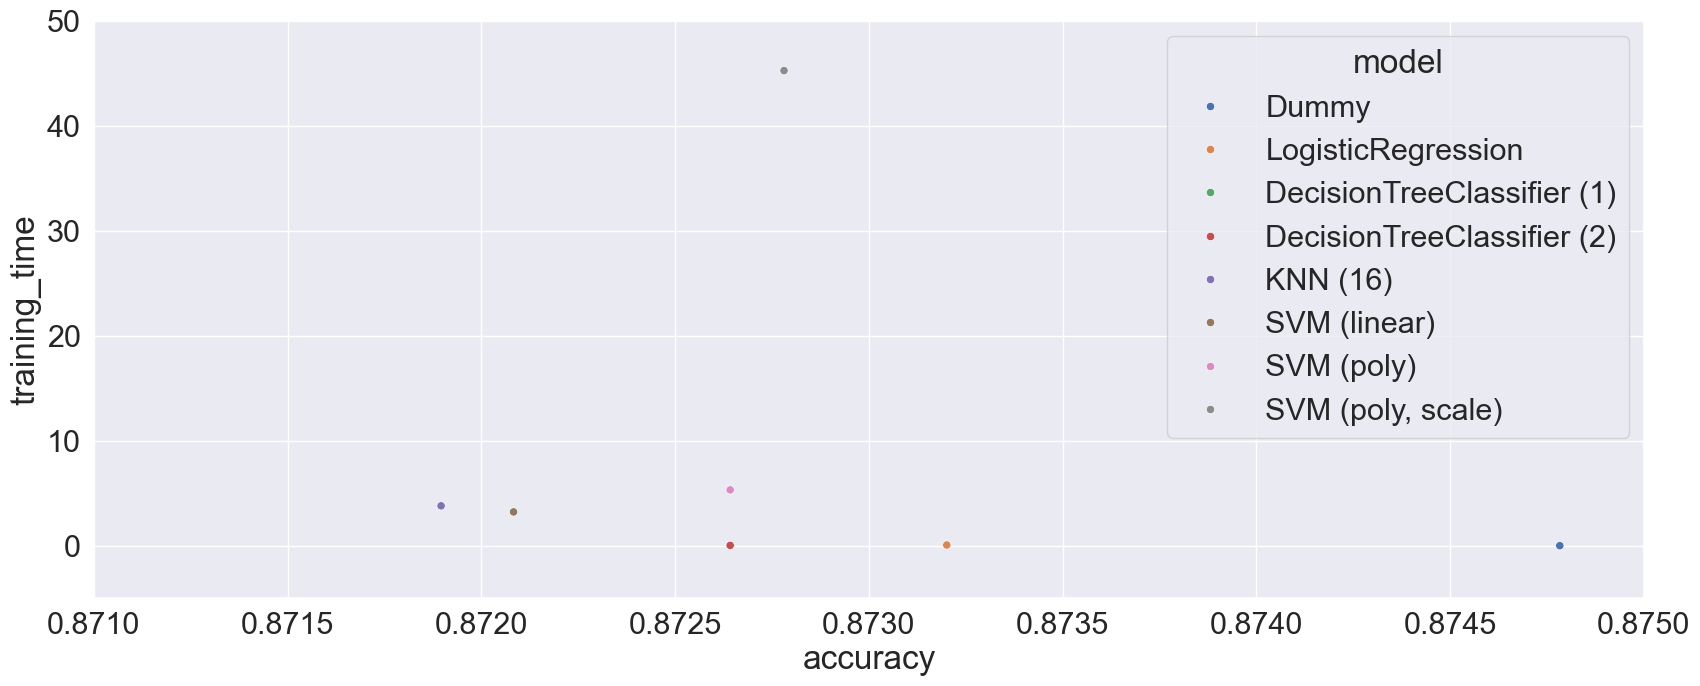

In [115]:
all_models = pd.DataFrame(
    {
        'model': [
            'Dummy', 'LogisticRegression', 'DecisionTreeClassifier (1)', 'DecisionTreeClassifier (2)', 'KNN (16)','SVM (linear)', 'SVM (poly)', 'SVM (poly, scale)'
        ],
        'training_time': [
            0.0067, 0.0711, 0.0588, 0.0328, 3.8013,3.2228, 5.3204, 45.2492
        ],   
        'accuracy': [
            0.874783, 0.873201, 0.872642,0.872642,0.871896,0.872083,0.872642,0.872781
        ]
    }
)
all_models

fig = plt.figure(figsize=(20,7.5))
ax = sns.scatterplot(data=all_models, y="training_time", x="accuracy", hue='model')
ax.set(ylim=(-5, 50))
ax.set(xlim=(0.871, 0.875))